##### In this notebook is presented a pipeline for the application of the Belkin O'Reilly Algorithm (BOA) to several images, and calculate the respective Frontal Probabilities matrix for the period in question. 


When applying BOA to an image, one obtains a matrix whose pixel values correspond to some sort of temperature gradients between adjacent pixels (unlike the Canny and Cayula-Cornillon algorithms where the pixel is either detected as being a front or not). Thus, to generate a front probability matrix for the BOA, one of the solutions is to set a threshold (if the pixel value is greater than the threshold, then it is considered a front, otherwise the pixel is not considered a front). This threshold value can be changed for visualization purposes.






In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
import cv2
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = 12, 10
%matplotlib inline

## Functions for the application of the Belkin O'Reilly Algorithm (BOA)

In [2]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan     # creates 1D array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)       # outgrid is a matrix with the shape of ingrid, full of Zeros

    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)]   #return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:              #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                if ma==12 or mi==12:     #if ma or mi is the middle value of 5X5 matrix (if the central pixel is the maximum)
                    outgrid[i-1,j-1] = 1      #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0      #all other pixels are flagged as 0
    
    return outgrid

In [3]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]       # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                   # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()          # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())            # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())            # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #if ma or mi is the middle value of 3X3 matrix
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [4]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)                                   #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #put values of filt in middle of matrix wf

        wf = fft2(wf)                                      #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        #this indices will be used to reorder values of matrix y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999)    #replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matrix with shape of grid35 (True if value is nan, False otherwise)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))    
    front = np.sqrt((tx**2)+(ty**2))                   

#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)         #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size                                      #nr of elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)                               #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi                      #change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

## Import MUR data

In the data directory there are several netCDF files with MUR and Reanalysis data.

In [5]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if MUR data, rename columns and convert temperature to Celsius (the data must be saved as 'mur...nc')
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [6]:
#Import the netCDF of MUR data from September 2019 and convert it to a dataframe
df_mur_sept = get_data('murSept2019.nc')

In [7]:
#Import the netCDF of MUR data from August 2019 and convert it to a dataframe
df_mur_aug = get_data('murAugust2019.nc')

In [8]:
#Import the netCDF of MUR data from July 2019 and convert it to a dataframe
df_mur_july = get_data('murJuly2019.nc')

In [28]:
#Import the netCDF of Reanalysis data from 2014-2019 and convert it to a dataframe
df_reanalysis = get_data('IBI2014-2019.nc')   

In [8]:
def get_period(df):
    
    """
    Function that receives a dataframe with data of SST relative to different days 
    and returns a dictionaire of dataframes (for each different day) and an array with the different dates 
    its possible to find in our dataframe 
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    dict_df = {elem : pd.DataFrame for elem in specificday}

    for key in dict_df.keys():
        dict_df[key] = df[:][df['time'] == key]
        
    return dict_df, specificday

#after this function we only have to define the period we want to analyse

In [10]:
dict_df_mur_set, specificday_mur_set = get_period(df_mur_sept)
#dict_df_mur_set -> dictionaire of dataframes for each day of September 2019 of the MUR data
#specificday_mur_set -> array with all the days of september 2019

In [9]:
dict_df_mur_aug, specificday_mur_aug = get_period(df_mur_aug)

In [12]:
dict_df_mur_july, specificday_mur_july = get_period(df_mur_july)

In [13]:
dict_df_r, specificday_r = get_period(df_reanalysis)

NameError: name 'df_reanalysis' is not defined

#### Define a Period of time we want to analyse

Here we can choose the period of time (ex: summer of 2019) that we want to analyse

In [30]:
summer2019_r = specificday_r[(specificday_r >='2019-07-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]
#Array with string values of all the days in the Summer of 2019 for the Reanalysis data

In [12]:
set2019_mur = specificday_mur_set[(specificday_mur_set >='2019-09-01 09:00:00') & (specificday_mur_set<='2019-09-30 09:00:00')]
#Array with string values of all the days in September2019 for the MUR data

## Pipeline for the aplication of BOA

In [12]:
def BOA_aplication(df, threshold=0.05):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
    ingrid = np.array(df['thetao']).reshape(len(lat), len(lon))
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    front = np.where(front>=threshold, 1, front)    
    front = np.where(front<threshold, 0, front)
    
    return front

In [13]:
def frontal_prob_boa(period, df, MUR=False, threshold=0.1):
    
    """
    Function applies BOA to several images and returns the matrix of frontal probabilities for certain period.
    The matrices resulting from the application of BOA are summed and divided by the number of periods
    to obtain a front probabilities matrix.
    """
    
    #if statment to define array shape based on which data it is
    if MUR==False:                      #reanalysis data
        fp = np.zeros((121,169))
    elif MUR==True: 
        fp = np.zeros((1001,1401))
        
    for day in period:
        fp = fp + BOA_aplication(df[day], threshold=threshold)
    
    fp = fp/(len(period))*100     #for the calculation of the FP we divide by the number of periods (days) 
    
    return fp

In [14]:
def BOA_visualization(period, df, MUR, threshold=0.1, vmin=None, vmax=None):
    
    """
    Function to visualize the frontal probabilities map.
    """
    
    fp = frontal_prob_boa(period=period, df=df, MUR=MUR, threshold=threshold)
    
    
    lat = np.array(df[period[0]]['latitude'].unique())
    lon = np.array(df[period[0]]['longitude'].unique())
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]], interpolation='gaussian')
    #extent is to define the extension of x and y axis in image
    plt.xlim([-18.95, -5])
    plt.ylim([35.05, 45])
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    plt.title("BOA Frontal Probabilities Summer 2019 (MUR)", fontsize=20)

    
    return fp

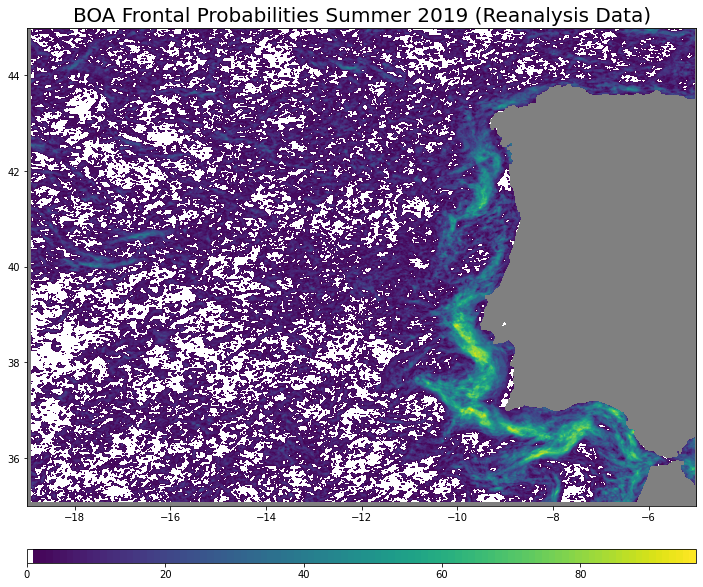

In [16]:
fp = BOA_visualization(period = specificday_mur_aug, df=dict_df_mur_aug, MUR=True)

#### To aggregate the various netCDFs from the MUR data and apply the algorithm

Due to their size the netCDF files for the MUR data were imported separately (1 month at a time). Thus the code below is just to merge several netCDFs in order to apply the Belkin O'Reilly Algorithm to a larger time spectrum.

In [17]:
def Merge(dict1, dict2):
    """
    Function to merge 2 dictionaires
    """
    
    res = {**dict1, **dict2}
    return res

In [18]:
dict_df_mur_augSet = Merge(dict_df_mur_aug, dict_df_mur_set)

In [19]:
dict_df_mur_summer = Merge(dict_df_mur_july, dict_df_mur_augSet)

In [20]:
specificday_mur_summer = np.concatenate([specificday_mur_july, specificday_mur_aug, specificday_mur_set])
#concatenate the 3 arrays together -> now we have array with all the string dates of all days of Summer 2019

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

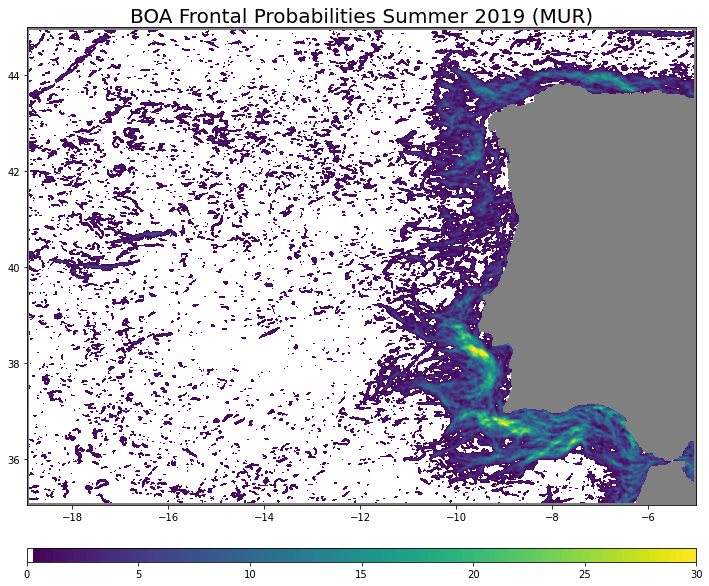

In [26]:
BOA_visualization(period=specificday_mur_summer, df=dict_df_mur_summer, MUR=True, vmax=30, threshold=0.1)  